In [1]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt
import os

In [2]:
# Open datasets, squeeze and set time coordinates

dpath = '/data/pstar_akeake/cruise/data/met/'

dstw = xr.open_mfdataset(dpath+'atmos_truewind_dy204.nc').squeeze() # 
dsso = xr.open_mfdataset(dpath+'surface_ocean_dy204.nc').squeeze()
dsws = xr.open_mfdataset(dpath+'windsonic_dy204_all_edt.nc').squeeze()
dssb = xr.open_mfdataset(dpath+'sbe45_dy204_all_edt.nc').squeeze()
dsba = xr.open_mfdataset(dpath+'../bathy/bathy_dy204.nc').squeeze()

dstw = dstw.set_coords('times')
dsso = dsso.set_coords('times')
dsws = dsws.set_coords('time')
dssb = dssb.set_coords('time')
dsba = dsba.set_coords('times')

In [3]:
# Select time period to analyse

cruise_dates = slice('2026-02-02 16:10:00','2026-02-09')

dstw = dstw.sel(times=cruise_dates)
dsso = dsso.sel(times=cruise_dates)
dsws = dsws.sel(time=cruise_dates)
dssb = dssb.sel(time=cruise_dates)
dsba = dsba.sel(times=cruise_dates)

In [4]:
def clean_data(data, method, fillna=True, dim='nrows1'):
# Function to remove outliers from time series data
# Methods:
#   "quant" - remove extreme values based on quantile alone (use with caution!)
#   "IQR"   - remove extreme values based on distance beyond the interquartile range
#   "zscore"- remove extreme values based on z score
#
# Note: All methods currently have hard-coded thresholds - adjust as appropriate
#       Outliers are anticipated to be only a small number of points - check interpolation is appropriate if not!
# 
# Author Adam Blaker (08/02/2026)
    
    
    if (method == "quant"): 
        # Define bounds (e.g., 1st and 99th percentiles) - not a good choice - it will clip data
        lower_bound = data.quantile(0.004)
        upper_bound = data.quantile(0.996)
        
        # Mask outliers with NaN
        cleaned_data = data.where((data >= lower_bound) & (data <= upper_bound))
    
    if (method == "IQR"):
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 2.5 * iqr
        upper_bound = q3 + 2.5 * iqr
        
        # Replace values outside 2.5*IQR with NaN
        cleaned_data = data.where((data >= lower_bound) & (data <= upper_bound))

    if (method == "zscore"):
        sigma = 5
        z = abs((data - data.mean()) / data.std(ddof=1))
        
        cleaned_data = data.where((z < sigma))

    if fillna:
        cleaned_data = cleaned_data.interpolate_na(dim=dim)
    
    return cleaned_data

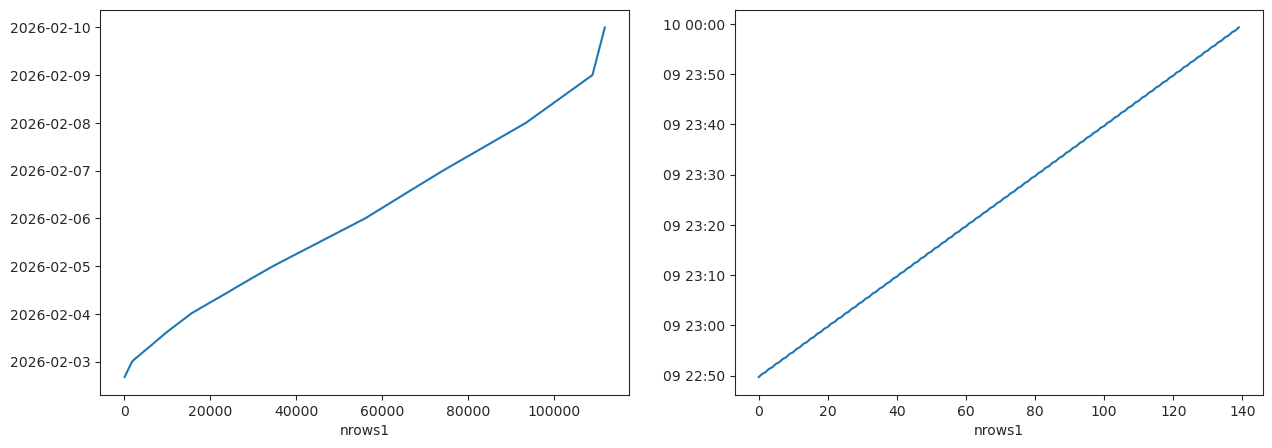

In [17]:
# Time increments vary throughout the data
fig, axs = plt.subplots(1,2, figsize=[15,5], sharex=False)

dsso['times'][:].plot(ax=axs[0])
dsso['times'][-140:].plot(ax=axs[1])

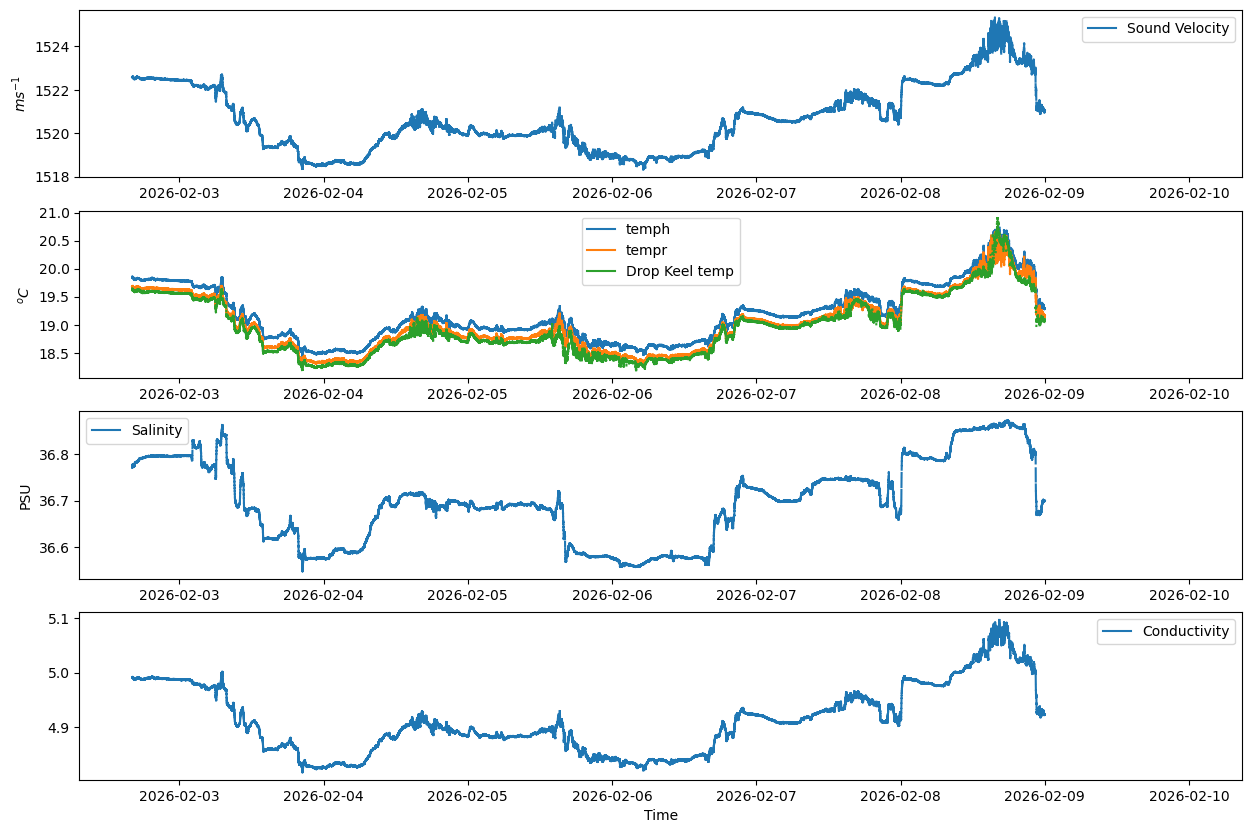

In [6]:
# Plot surface ocean variables
fig, axs = plt.subplots(4, figsize=[15,10], sharex=True)

axs[0].plot(dsso['times'],dsso['soundvelocity'],label='Sound Velocity');
axs[1].plot(dsso['times'],dsso['temph'],label='temph');
axs[1].plot(dsso['times'],dsso['tempr'],label='tempr');
axs[1].plot(dsso['times'],dsso['tempdk'],label='Drop Keel temp');
axs[2].plot(dsso['times'],dsso['salinity'],label='Salinity');
axs[3].plot(dsso['times'],dsso['conductivity'],label='Conductivity');

for ax in axs:
    ax.legend()
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

axs[0].set_ylabel('$m s^{-1}$')
axs[1].set_ylabel('$^{o} C$')
axs[2].set_ylabel('PSU')

axs[3].set_xlabel('Time');

fig.savefig(fname='DY204_surface_ocean_variables.pdf', format='pdf')
fig.savefig(fname='DY204_surface_ocean_variables.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

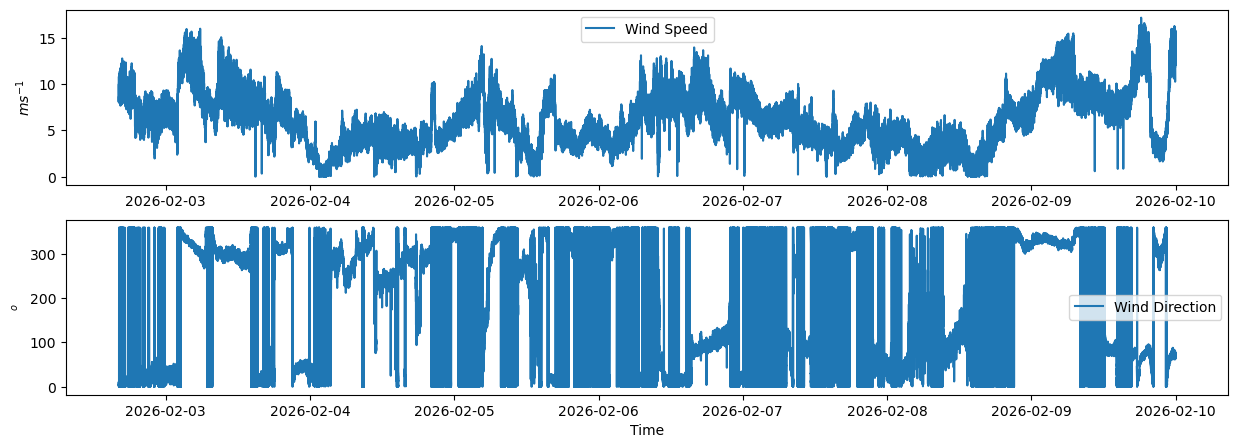

In [7]:
# Plot surface ocean variables
fig, axs = plt.subplots(2, figsize=[15,5], sharex=True)

zclean_windspd = clean_data(dsws['windspeed'], method='zscore')

axs[0].plot(dsws['time'],zclean_windspd, label="Wind Speed")
axs[1].plot(dsws['time'],dsws['winddirection'], label="Wind Direction")

for ax in axs:
    ax.legend()
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    
axs[0].set_ylabel('$m s^{-1}$')
axs[1].set_ylabel('$^{o}$')

axs[1].set_xlabel('Time');

fig.savefig(fname='DY204_windspeed_and_direction.pdf', format='pdf')
fig.savefig(fname='DY204_windspeed_and_direction.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

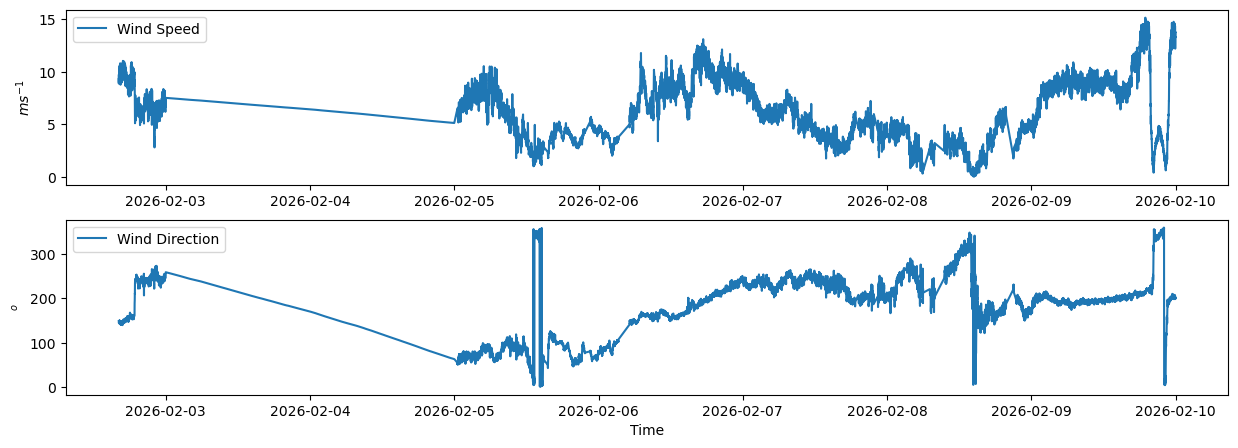

In [8]:
# Plot surface ocean variables - lots of gaps filled in the true windspeed and direction
fig, axs = plt.subplots(2, figsize=[15,5], sharex=True)

zclean_truwindspd = clean_data(dstw['truwind_spd'], method='zscore')
zclean_truwinddir = clean_data(dstw['truwind_dir'], method='zscore')

axs[0].plot(dstw['times'],zclean_truwindspd, label="Wind Speed")
axs[1].plot(dstw['times'],zclean_truwinddir, label="Wind Direction")

for ax in axs:
    ax.legend()
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    
axs[0].set_ylabel('$m s^{-1}$')
axs[1].set_ylabel('$^{o}$')

axs[1].set_xlabel('Time');

fig.savefig(fname='DY204_true_windspeed_and_direction.pdf', format='pdf')
fig.savefig(fname='DY204_true_windspeed_and_direction.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

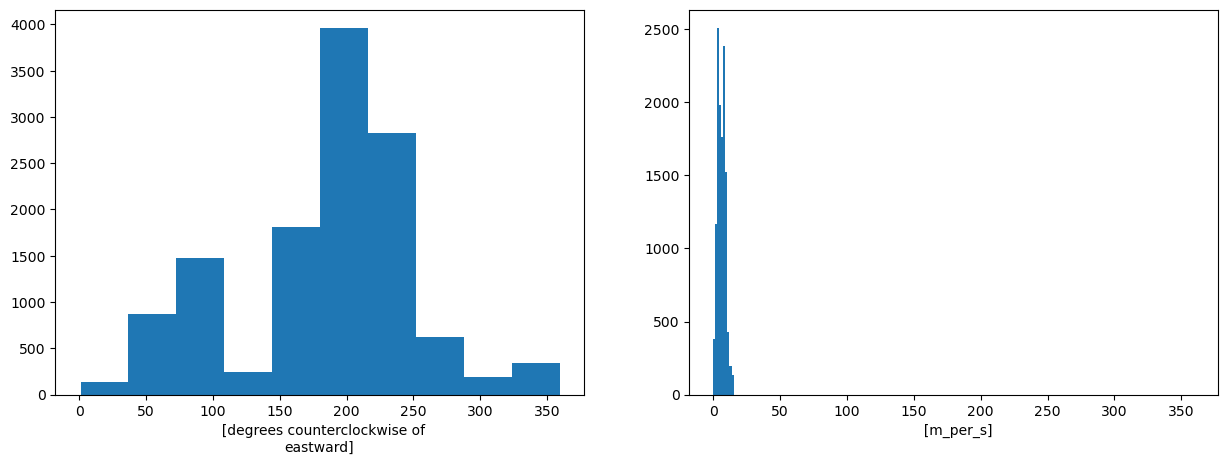

In [9]:
fig, axs = plt.subplots(1,2, figsize=[15,5], sharex=True)

dstw['truwind_dir'].plot.hist(ax=axs[0]);
dstw['truwind_spd'].plot.hist(ax=axs[1]);

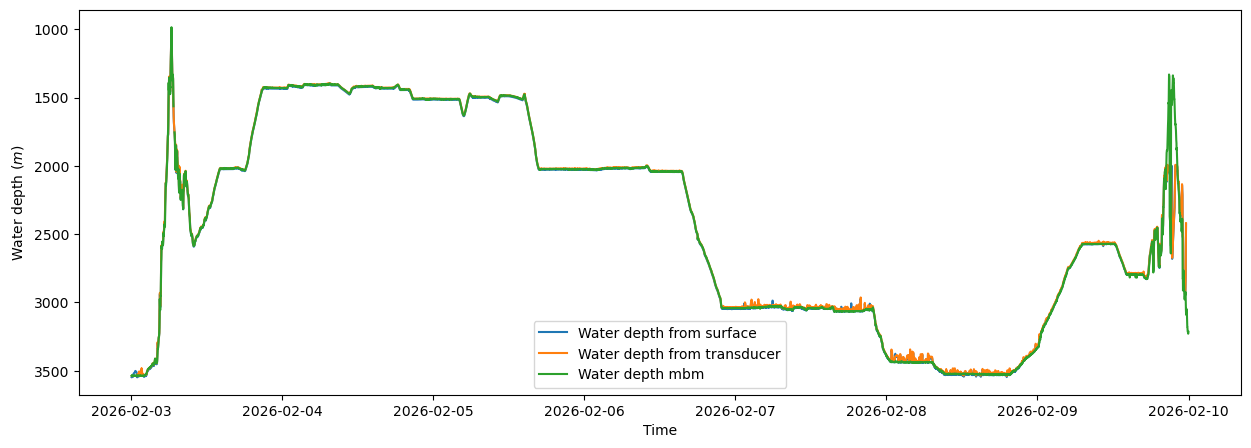

In [10]:
# Plot edited water depth variables from bathy_dy204.nc
fig, axs = plt.subplots(1, figsize=[15,5], sharex=True)

axs.plot(dsba['times'],dsba['waterdepthfromsurface_sbm'], label="Water depth from surface")
axs.plot(dsba['times'],dsba['waterdepthtransducer_sbm'], label="Water depth from transducer")
axs.plot(dsba['times'],dsba['waterdepth_mbm'], label="Water depth mbm")
#axs[3].plot(dsba['times'],dsba['waterdepthfromsurface_sbm'], label="Water depth from surface")


axs.legend()
axs.invert_yaxis()
axs.set_ylabel('Water depth ($m$)')

axs.set_xlabel('Time');

fig.savefig(fname='DY204_water_depth.pdf', format='pdf')
fig.savefig(fname='DY204_water_depth.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

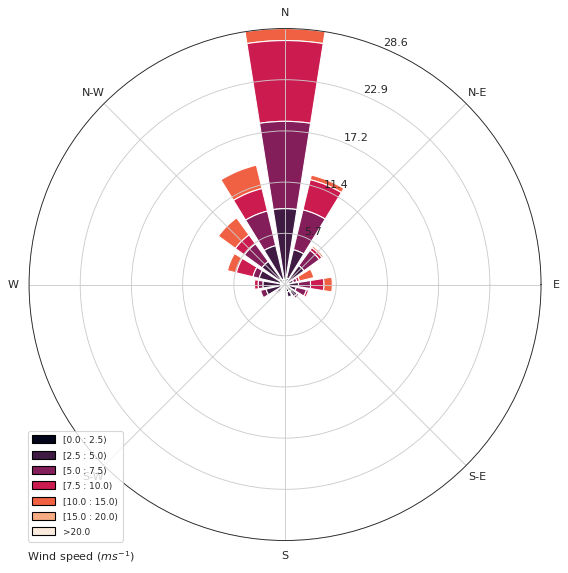

In [11]:
import numpy
import pandas
from matplotlib import pyplot
from windrose import WindroseAxes
import seaborn

seaborn.set_style('ticks')

spd_bins = [0, 2.5, 5, 7.5, 10, 15, 20]


wr = xr.merge([zclean_windspd, dsws['winddirection']])

# 2. Convert to Pandas
wrp = wr.to_dataframe()

# 3. Create Wind Rose
ax = WindroseAxes.from_ax()
ax.bar(wrp['winddirection'], wrp['windspeed'], normed=True, opening=0.8, edgecolor='white', bins = spd_bins)
ax.set_legend()
#plt.show()

ax.annotate(' Wind speed ($m s^{-1}$)', xy=(-0.01, -.04), xycoords="axes fraction")

plt.savefig(fname='DY204_windrose.pdf', format='pdf')
plt.savefig(fname='DY204_windrose.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

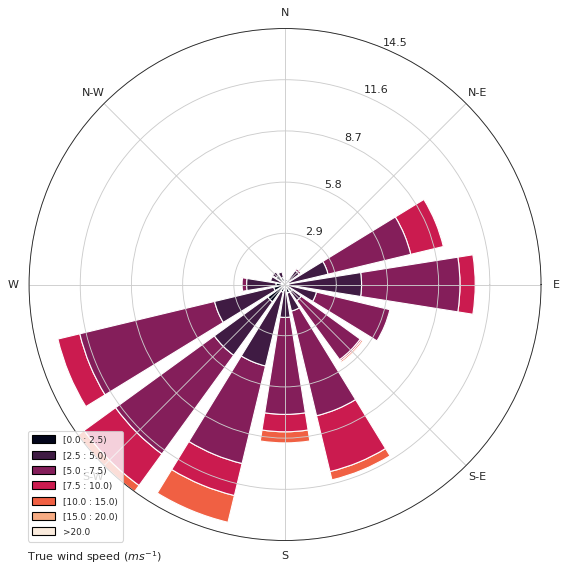

In [12]:
import numpy
import pandas
from matplotlib import pyplot
from windrose import WindroseAxes
import seaborn

seaborn.set_style('ticks')

spd_bins = [0, 2.5, 5, 7.5, 10, 15, 20]


wr = xr.merge([zclean_truwindspd, zclean_truwinddir])

# 2. Convert to Pandas
wrp = wr.to_dataframe()

# 3. Create Wind Rose
ax = WindroseAxes.from_ax()
ax.bar(wrp['truwind_dir'], wrp['truwind_spd'], normed=True, opening=0.8, edgecolor='white', bins = spd_bins)
ax.set_legend()
#plt.show()

ax.annotate(' True wind speed ($m s^{-1}$)', xy=(-0.01, -.04), xycoords="axes fraction")

plt.savefig(fname='DY204_truewindrose.pdf', format='pdf')
plt.savefig(fname='DY204_truewindrose.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)